In [1]:
import numpy as np
import matplotlib.pyplot as plt

colors = ['skyblue','indianred']

## <font color='cornflowerblue'> Kalman Filters Class

In [2]:
class KalmanFilter:
    def __init__(self, n: int, R: float = 1.0, F: np.ndarray = None, Q: np.ndarray = None, P0: np.ndarray = None, w0: np.ndarray = None):
        """
        Kalman Filter for online linear regression (time-varying weights).
        """
        self.n = n
        self.R = R
        self.F = F
        self.Q = Q
        self.P0 = P0
        self.w0 = w0

        if self.F is None:
            self.F = np.eye(n)
        if self.P0 is None:
            self.P0 = np.eye(n) * 0.01
        if self.w0 is None:
            self.w0 = np.zeros(n)
        if self.Q is None:
            self.Q = np.eye(n) * 0.001

        self.w_t = self.w0.copy()
        self.P_t = self.P0.copy()
        self.initialized = True

    def predict(self) -> tuple[np.ndarray, np.ndarray]:
        """Prediction step: returns w_pred, P_pred."""

        w_pred = self.F @ self.w_t
        P_pred = self.F @ self.P_t @ self.F.T + self.Q
        return w_pred, P_pred

    def update(self, x_t: np.ndarray, y_t: float, w_pred: np.ndarray, P_pred: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """Update step: given observation (x_t, y_t), return updated weights and covariance."""
        H_t = x_t.reshape(1, -1)

        K_t = P_pred @ H_t.T @ np.linalg.inv(H_t @ P_pred @ H_t.T + self.R)
        w_upd = w_pred + K_t.flatten() * (y_t - H_t @ w_pred)
        P_upd = (np.eye(self.n) - K_t @ H_t) @ P_pred

        self.w_t = w_upd
        self.P_t = P_upd

        return w_upd, P_upd

## <font color='cornflowerblue'> Pairs Trading

In [3]:
import yfinance as yf
import statsmodels.api as sm

In [4]:
tickers = ['CSCO', 'CRM']
start_date = '2010-01-01'
end_date = '2025-10-14'

data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close'][tickers]

YF.download() has changed argument auto_adjust default to True


In [5]:
window_size = 50

X_window = np.ones(window_size).reshape(-1, 1)
X_window = np.hstack([X_window, data.iloc[:window_size, 0].values.reshape(-1, 1)])
    
y_window = data.iloc[:window_size, 1].values.reshape(-1, 1)

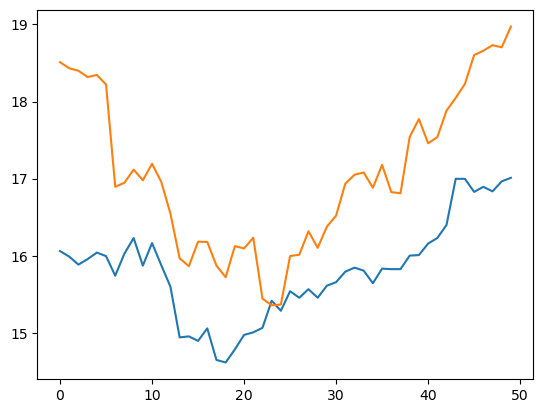

In [6]:
plt.plot(X_window[:, 1])
plt.plot(y_window)

In [7]:
w_0, w_1 = np.array([0, (y_window[-1] / X_window[-1, 1])[0]])

In [8]:
spread = y_window - w_1 * X_window[:, 1].reshape(-1, 1) - w_0
normalized_spread = (spread - spread.mean()) / spread.std()

In [9]:
X = np.ones((len(data.iloc[window_size:]), 1))
X = np.hstack([X, data.iloc[window_size:, 0].values.reshape(-1, 1)])

y = data.iloc[window_size:, 1].values.reshape(-1, 1)

n = X.shape[1]
R = 1
F = np.eye(n)
Q = np.eye(n) * 0.001
P_t = np.eye(n) * 0.01
w_t = np.array([0, (y_window[-1] / X_window[-1, 1])[0]])

In [10]:
new_data = data.iloc[window_size:]
kalman = KalmanFilter(n=n, R=R, F=F, Q=Q, P0=P_t, w0=w_t)
w = np.zeros((len(X), n))
historical_norm_spread = []

#for i in range(len(X)):
for i, row in enumerate(new_data.itertuples(index=True)):
    x_t = X[i]
    y_t = y[i]

    # Prediction
    w_pred, P_pred = kalman.predict()

    # Update step
    w_upd, P_upd = kalman.update(x_t, y_t, w_pred, P_pred)

    # Spread calculation
    spread_t = y_t - w_upd[1] * x_t[1] - w_upd[0]
    # Rolling window for spread
    spread = np.delete(spread, 0)
    spread = np.append(spread, spread_t)
    # Normalization
    normalized_spread = (spread[-1] - np.mean(spread)) / np.std(spread)
    historical_norm_spread.append(normalized_spread)

    # Use w_upd for hedge ratio
    w[i, :] = w_upd

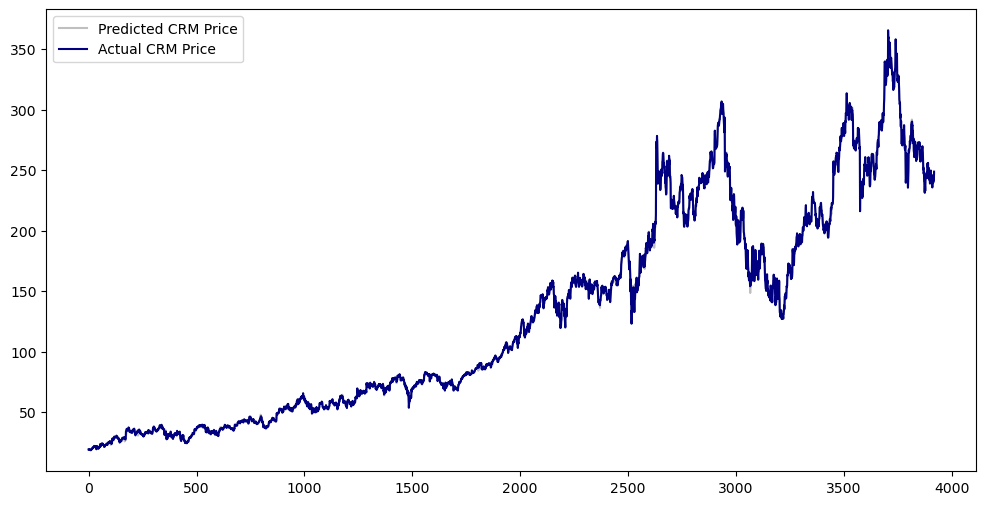

In [11]:
data_vec = np.ones((new_data.shape[0], 1))
data_vec = np.hstack([data_vec, new_data.values[:,0].reshape(-1, 1)])
preds = np.array([data_vec[t] @ w[t] for t in range(new_data.shape[0])])
y_price = new_data.values[:,1]

plt.figure(figsize=(12, 6))
plt.plot(preds, label=f'Predicted {tickers[1]} Price', color='gray', alpha = 0.5)
plt.plot(y_price, label=f'Actual {tickers[1]} Price', color='navy')
plt.legend()
plt.show()

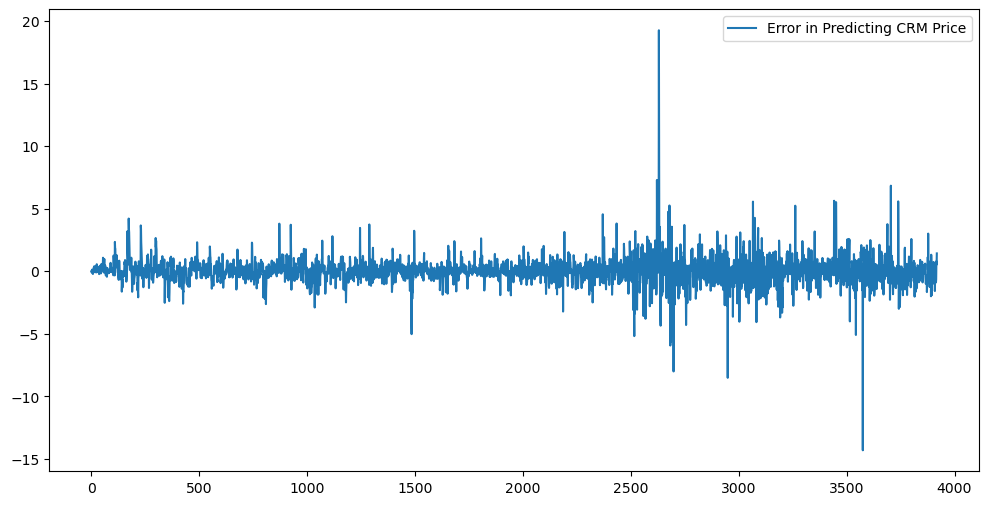

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(y_price - preds, label =f'Error in Predicting {tickers[1]} Price')
plt.legend()
plt.show()

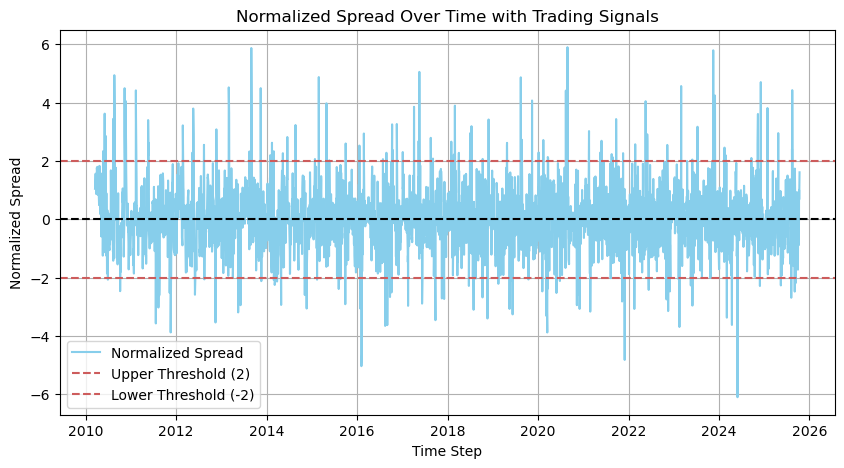

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(new_data.index, historical_norm_spread, label='Normalized Spread', color='skyblue')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(2, color='indianred', linestyle='--', label='Upper Threshold (2)')
plt.axhline(-2, color='indianred', linestyle='--', label='Lower Threshold (-2)')
plt.title('Normalized Spread Over Time with Trading Signals')
plt.xlabel('Time Step')
plt.ylabel('Normalized Spread')
plt.legend()
plt.grid()
plt.show()

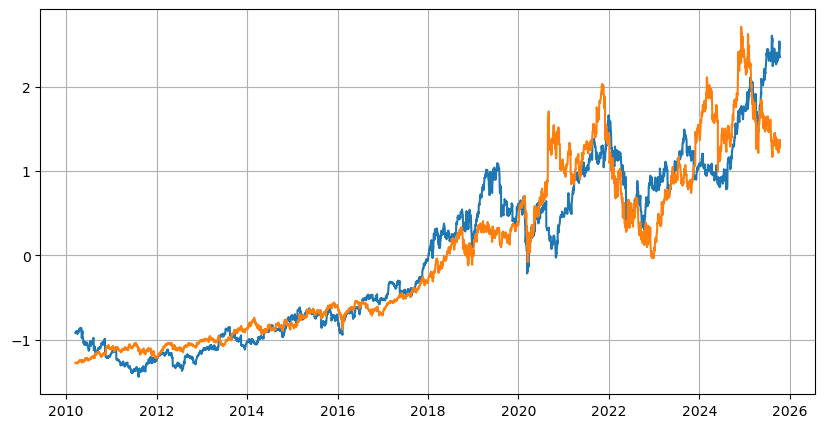

In [14]:
norm_data = (new_data - new_data.mean()) / new_data.std()

plt.figure(figsize=(10, 5))
plt.plot(norm_data)
plt.grid()
plt.show()

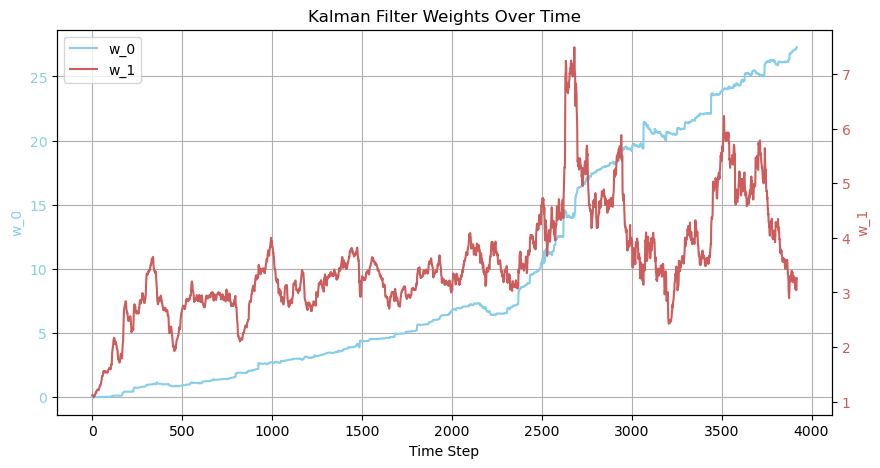

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

# Left y-axis for w_0
l1, = ax.plot(w[:, 0], color=colors[0], label='w_0')
ax.set_ylabel('w_0', color=colors[0])
ax.tick_params(axis='y', labelcolor=colors[0])

# Right y-axis for w_1
ax2 = ax.twinx()
l2, = ax2.plot(w[:, 1], color=colors[1], label='w_1')
ax2.set_ylabel('w_1', color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])

ax.set_title('Kalman Filter Weights Over Time')
ax.set_xlabel('Time Step')
ax.grid(True)

# Combined legend
lines = [l1, l2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='best')

plt.show()